# CheXScan Ensemble Experiments

## Libraries

In [1]:
import tensorflow as tf
from keras import datasets, layers, models
from keras.optimizers import Adam
from keras.optimizers import Adam as LegacyAdam
from keras.layers import Input, Average
from keras.applications import DenseNet121, InceptionV3, ResNet50, VGG16
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

## GPU Utilization

checks for available physical devices using TensorFlow's configuration

In [2]:
physical_devices = tf.config.list_physical_devices()

print("Available physical devices:")
for device in physical_devices:
    print(device)

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available")
    for gpu in gpu_devices:
        print("GPU device name:", gpu.name)
else:
    print("GPU is NOT available, using CPU")

Available physical devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU is available
GPU device name: /physical_device:GPU:0


In [3]:
# Get the list of available physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# Check if there are GPUs available
if gpus:
    # Set memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPU:", gpu)
else:
    print("No GPUs found.")

Memory growth set for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
CLASSES = ['normal', 'pneumonia', 'tuberculosis']
NUM_CLASSES = len(CLASSES)
EPOCHS = 10

## Access image directory

In [5]:
# Access image directory
root_dir = r"E:/chexscan/data"
train_dir = root_dir + "/train_data"
valid_dir = root_dir + "/test_data"

## Data Generator

In [6]:
img_size = IMAGE_SIZE

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip = True,
    zoom_range=0.2,
    fill_mode="constant",
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4800 images belonging to 3 classes.


In [7]:
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 1200 images belonging to 3 classes.


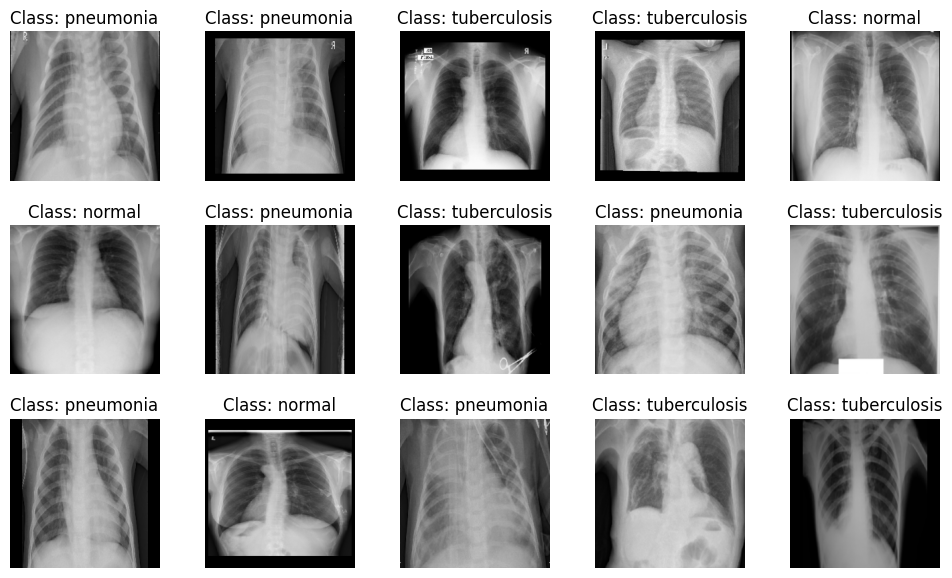

In [8]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])

    # Convert the float target to integer (0 or 1)
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

## Training Parameters

In [9]:
loss_function = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.0001)
num_epochs = EPOCHS

## Evaluation Functions

In [10]:
def evaluate_model(model, valid_generator):
    predictions = model.predict_generator(valid_generator)
    true_labels = valid_generator.classes
    return true_labels, np.argmax(predictions, axis=1)

In [11]:
def plot_history_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## TRAINING

defines the model architecture with convolutional and max-pooling layers, followed by fully connected layers and dropout regularization. 

compiled with a customized Adam optimizer and specified loss function. Training includes early stopping based on validation accuracy

after training, the model's performance is evaluated on a validation dataset, and metrics such as accuracy and classification report are computed.

visualizations, including training history and confusion matrix, are generated to assess the model's performance.

## AlexNet

Epoch 1/10
150/150 [==============================] - 64s 424ms/step - loss: 0.6913 - accuracy: 0.6544 - val_loss: 0.3772 - val_accuracy: 0.8500
Epoch 2/10
150/150 [==============================] - 63s 420ms/step - loss: 0.3997 - accuracy: 0.8285 - val_loss: 0.2833 - val_accuracy: 0.8792
Epoch 3/10
150/150 [==============================] - 63s 422ms/step - loss: 0.3449 - accuracy: 0.8544 - val_loss: 0.2464 - val_accuracy: 0.9025
Epoch 4/10
150/150 [==============================] - 63s 420ms/step - loss: 0.2891 - accuracy: 0.8775 - val_loss: 0.2897 - val_accuracy: 0.8750
Epoch 5/10
150/150 [==============================] - 63s 421ms/step - loss: 0.2639 - accuracy: 0.8973 - val_loss: 0.1852 - val_accuracy: 0.9317
Epoch 6/10
150/150 [==============================] - 63s 424ms/step - loss: 0.2409 - accuracy: 0.9077 - val_loss: 0.2107 - val_accuracy: 0.9117
Epoch 7/10
150/150 [==============================] - 63s 423ms/step - loss: 0.2111 - accuracy: 0.9129 - val_loss: 0.1711 - val_ac

C:\Users\faith\AppData\Local\Temp\ipykernel_16212\731272717.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_generator)


AlexNet Accuracy: 0.945


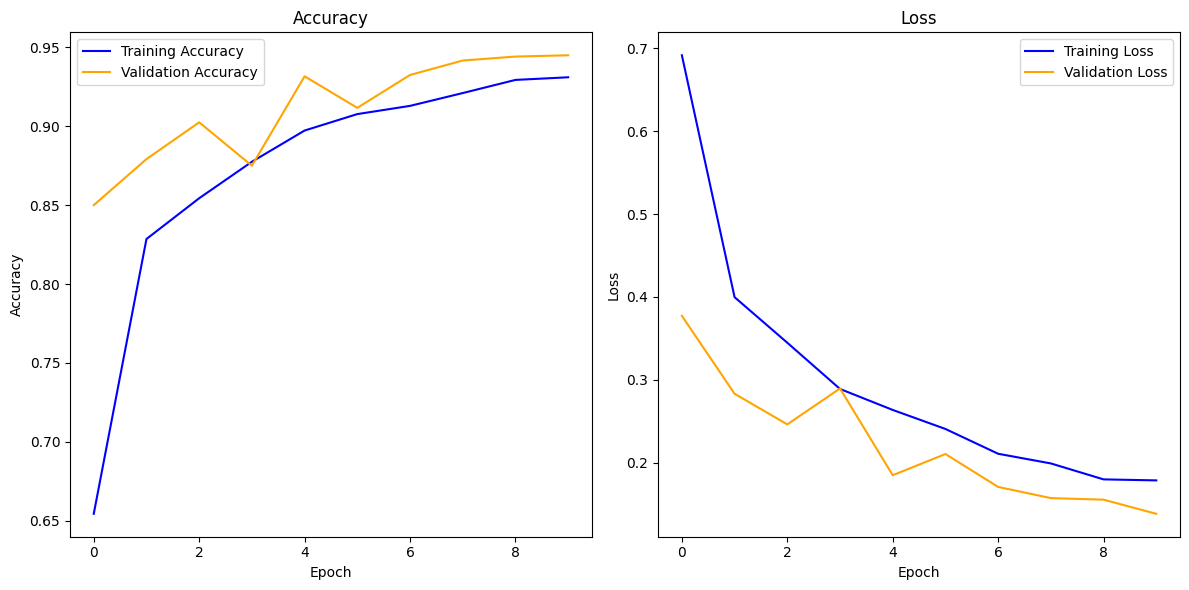

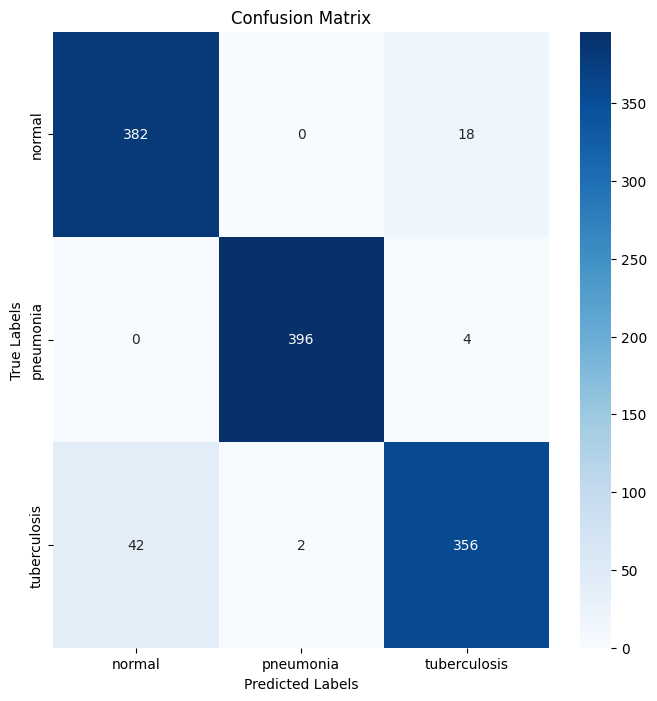

Classification Report for AlexNet:
              precision    recall  f1-score   support

      normal       0.90      0.95      0.93       400
   pneumonia       0.99      0.99      0.99       400
tuberculosis       0.94      0.89      0.92       400

    accuracy                           0.94      1200
   macro avg       0.95      0.94      0.94      1200
weighted avg       0.95      0.94      0.94      1200



In [14]:
alexnet_model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

alexnet_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

history_alexnet = alexnet_model.fit(train_generator,
                                    validation_data=valid_generator,
                                    epochs=num_epochs,
                                    callbacks=[early_stopping])

true_labels_alexnet, predicted_labels_alexnet = evaluate_model(alexnet_model, valid_generator)
accuracy_alexnet = accuracy_score(true_labels_alexnet, predicted_labels_alexnet)
print("AlexNet Accuracy:", accuracy_alexnet)

plot_history_metrics(history_alexnet)

plot_confusion_matrix(true_labels_alexnet, predicted_labels_alexnet, CLASSES)

print("Classification Report for AlexNet:")
print(classification_report(true_labels_alexnet, predicted_labels_alexnet, target_names=CLASSES))

## DenseNet-121

Epoch 1/10
150/150 [==============================] - 72s 443ms/step - loss: 0.2523 - accuracy: 0.9006 - val_loss: 1.2072 - val_accuracy: 0.6025
Epoch 2/10
150/150 [==============================] - 66s 439ms/step - loss: 0.0734 - accuracy: 0.9748 - val_loss: 0.0955 - val_accuracy: 0.9650
Epoch 3/10
150/150 [==============================] - 66s 437ms/step - loss: 0.0435 - accuracy: 0.9856 - val_loss: 0.0490 - val_accuracy: 0.9808
Epoch 4/10
150/150 [==============================] - 66s 438ms/step - loss: 0.0340 - accuracy: 0.9885 - val_loss: 0.0257 - val_accuracy: 0.9908
Epoch 5/10
150/150 [==============================] - 66s 439ms/step - loss: 0.0256 - accuracy: 0.9921 - val_loss: 0.5527 - val_accuracy: 0.8342
Epoch 6/10
150/150 [==============================] - 66s 436ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.3110 - val_accuracy: 0.8942
Epoch 7/10
150/150 [==============================] - 66s 436ms/step - loss: 0.0232 - accuracy: 0.9919 - val_loss: 0.0748 - val_ac

C:\Users\faith\AppData\Local\Temp\ipykernel_16212\731272717.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_generator)


DenseNet121 Accuracy: 0.94


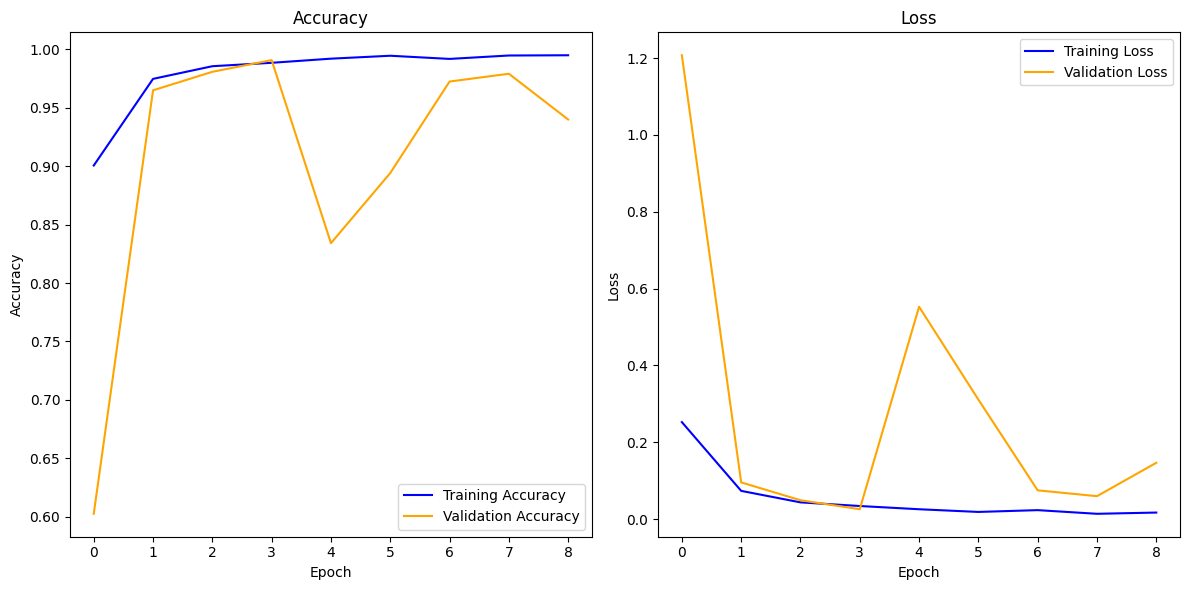

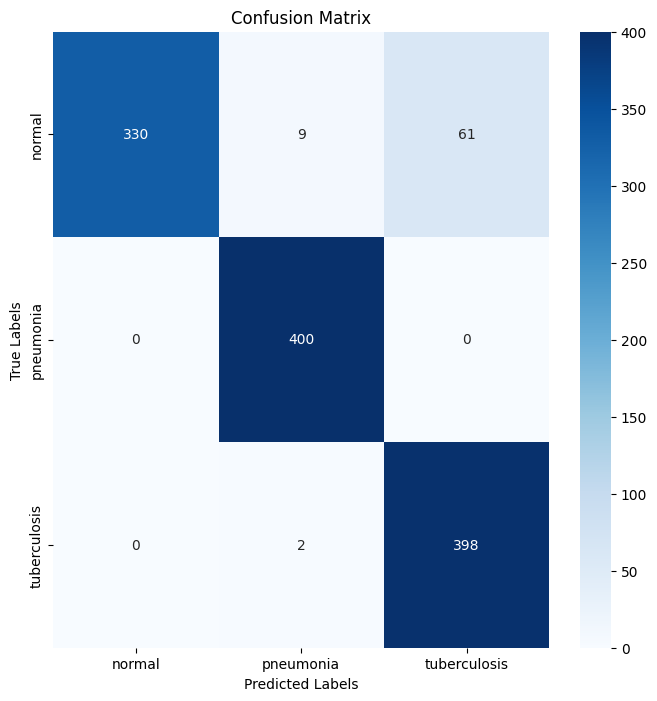

Classification Report for DenseNet121:
              precision    recall  f1-score   support

      normal       1.00      0.82      0.90       400
   pneumonia       0.97      1.00      0.99       400
tuberculosis       0.87      0.99      0.93       400

    accuracy                           0.94      1200
   macro avg       0.95      0.94      0.94      1200
weighted avg       0.95      0.94      0.94      1200



In [16]:
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

densenet_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

densenet_model = tf.keras.Model(inputs=densenet_model.input, outputs=densenet_top(densenet_model.output))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

densenet_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

history_densenet = densenet_model.fit(train_generator, 
                                      validation_data=valid_generator, 
                                      epochs=num_epochs, 
                                      callbacks=[early_stopping])

true_labels_densenet, predicted_labels_densenet = evaluate_model(densenet_model, valid_generator)
accuracy_densenet = accuracy_score(true_labels_densenet, predicted_labels_densenet)
print("DenseNet121 Accuracy:", accuracy_densenet)

plot_history_metrics(history_densenet)

plot_confusion_matrix(true_labels_densenet, predicted_labels_densenet, CLASSES)

print("Classification Report for DenseNet121:")
print(classification_report(true_labels_densenet, predicted_labels_densenet, target_names=CLASSES))


## ResNet-50

Epoch 1/10
150/150 [==============================] - 70s 433ms/step - loss: 0.2009 - accuracy: 0.9204 - val_loss: 4.1179 - val_accuracy: 0.3333
Epoch 2/10
150/150 [==============================] - 64s 428ms/step - loss: 0.0522 - accuracy: 0.9829 - val_loss: 13.8355 - val_accuracy: 0.3333
Epoch 3/10
150/150 [==============================] - 64s 428ms/step - loss: 0.0447 - accuracy: 0.9846 - val_loss: 1.5785 - val_accuracy: 0.3325
Epoch 4/10
150/150 [==============================] - 64s 429ms/step - loss: 0.0387 - accuracy: 0.9862 - val_loss: 1.1608 - val_accuracy: 0.3950
Epoch 5/10
150/150 [==============================] - 64s 429ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 1.6271 - val_accuracy: 0.4867
Epoch 6/10
150/150 [==============================] - 64s 428ms/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 3.1434 - val_accuracy: 0.5625
Epoch 7/10
150/150 [==============================] - 65s 430ms/step - loss: 0.0194 - accuracy: 0.9948 - val_loss: 0.4582 - val_a

C:\Users\faith\AppData\Local\Temp\ipykernel_16212\731272717.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_generator)


ResNet50 Accuracy: 0.7933333333333333


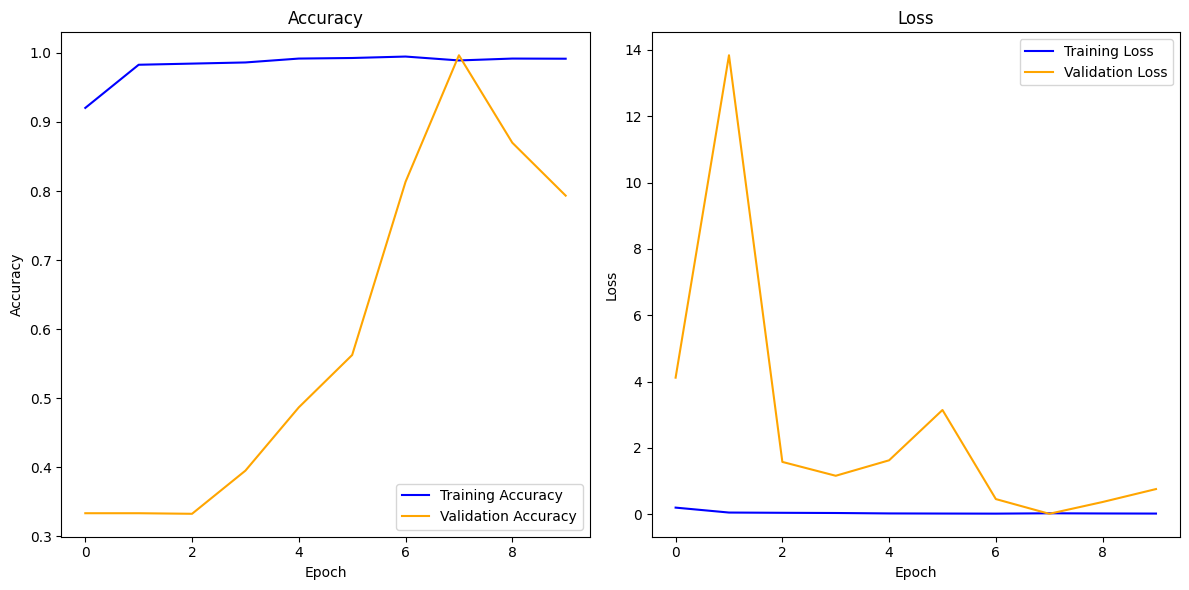

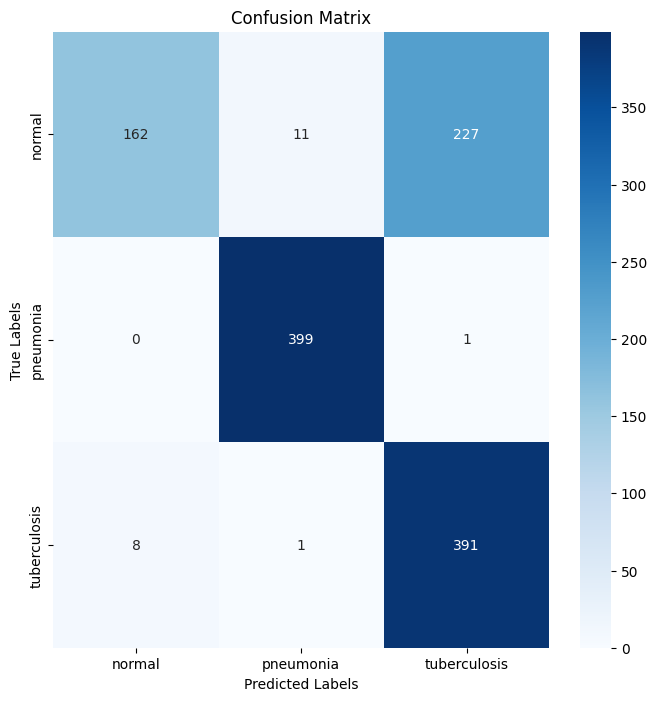

Classification Report for ResNet50:
              precision    recall  f1-score   support

      normal       0.95      0.41      0.57       400
   pneumonia       0.97      1.00      0.98       400
tuberculosis       0.63      0.98      0.77       400

    accuracy                           0.79      1200
   macro avg       0.85      0.79      0.77      1200
weighted avg       0.85      0.79      0.77      1200



In [17]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

resnet_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

resnet_model = tf.keras.Model(inputs=resnet_model.input, outputs=resnet_top(resnet_model.output))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

resnet_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history_resnet = resnet_model.fit(train_generator,
                                  validation_data=valid_generator,
                                  epochs=num_epochs,
                                  callbacks=[early_stopping])

true_labels_resnet, predicted_labels_resnet = evaluate_model(resnet_model, valid_generator)
accuracy_resnet = accuracy_score(true_labels_resnet, predicted_labels_resnet)
print("ResNet50 Accuracy:", accuracy_resnet)

plot_history_metrics(history_resnet)

plot_confusion_matrix(true_labels_resnet, predicted_labels_resnet, CLASSES)

print("Classification Report for ResNet50:")
print(classification_report(true_labels_resnet, predicted_labels_resnet, target_names=CLASSES))


## VGG-16

setting up an early stopping callback during model training to prevent overfitting and to stop training when the model performance stops improving

Epoch 1/10
150/150 [==============================] - 69s 454ms/step - loss: 0.5367 - accuracy: 0.7340 - val_loss: 0.1466 - val_accuracy: 0.9408
Epoch 2/10
150/150 [==============================] - 69s 456ms/step - loss: 0.2322 - accuracy: 0.9121 - val_loss: 0.1638 - val_accuracy: 0.9317
Epoch 3/10
150/150 [==============================] - 69s 457ms/step - loss: 0.1461 - accuracy: 0.9442 - val_loss: 0.1076 - val_accuracy: 0.9617
Epoch 4/10
150/150 [==============================] - 68s 452ms/step - loss: 0.0965 - accuracy: 0.9650 - val_loss: 0.0674 - val_accuracy: 0.9767
Epoch 5/10
150/150 [==============================] - 69s 457ms/step - loss: 0.0865 - accuracy: 0.9719 - val_loss: 0.0920 - val_accuracy: 0.9692
Epoch 6/10
150/150 [==============================] - 69s 458ms/step - loss: 0.1109 - accuracy: 0.9613 - val_loss: 0.0800 - val_accuracy: 0.9683
Epoch 7/10
150/150 [==============================] - 68s 450ms/step - loss: 0.0578 - accuracy: 0.9819 - val_loss: 0.0569 - val_ac

C:\Users\faith\AppData\Local\Temp\ipykernel_16212\731272717.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_generator)


VGG16 Accuracy: 0.9916666666666667


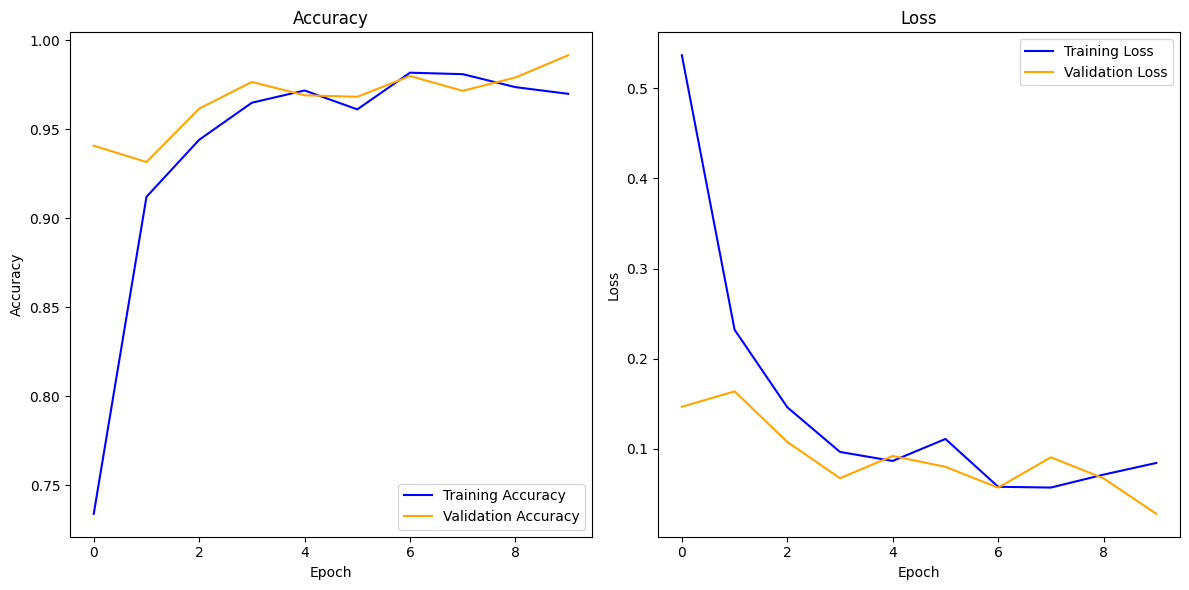

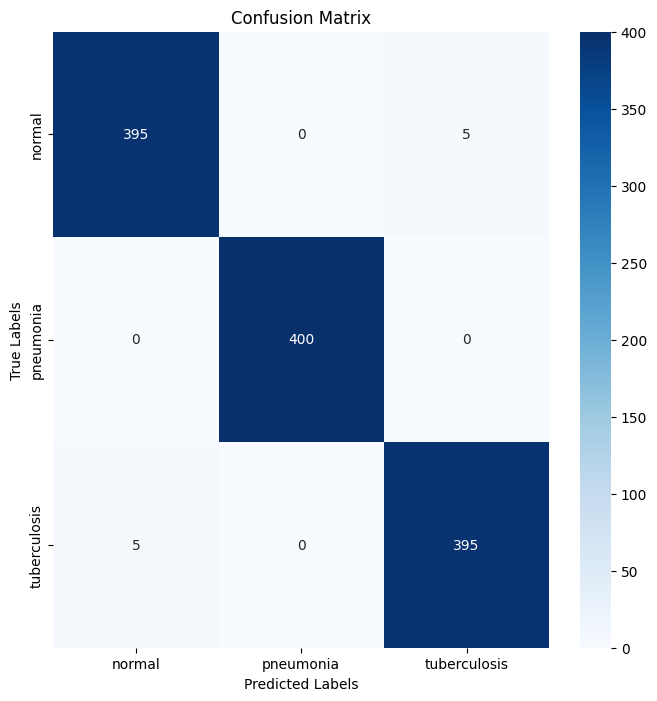

Classification Report for VGG16:
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       400
   pneumonia       1.00      1.00      1.00       400
tuberculosis       0.99      0.99      0.99       400

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [20]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

vgg_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

vgg_model = tf.keras.Model(inputs=vgg_model.input, outputs=vgg_top(vgg_model.output))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

vgg_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history_vgg = vgg_model.fit(train_generator, 
                            validation_data=valid_generator, 
                            epochs=num_epochs, 
                            callbacks=[early_stopping])

true_labels_vgg, predicted_labels_vgg = evaluate_model(vgg_model, valid_generator)
accuracy_vgg = accuracy_score(true_labels_vgg, predicted_labels_vgg)
print("VGG16 Accuracy:", accuracy_vgg)

plot_history_metrics(history_vgg)

plot_confusion_matrix(true_labels_vgg, predicted_labels_vgg, CLASSES)

print("Classification Report for VGG16:")
print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=CLASSES))


## Inception V3

Epoch 1/10
150/150 [==============================] - 69s 435ms/step - loss: nan - accuracy: 0.7777 - val_loss: nan - val_accuracy: 0.3333
Epoch 2/10
150/150 [==============================] - 65s 431ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 3/10
150/150 [==============================] - 65s 432ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 4/10
150/150 [==============================] - 65s 433ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 5/10
150/150 [==============================] - 65s 432ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 6/10
150/150 [==============================] - 65s 432ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 6: early stopping


C:\Users\faith\AppData\Local\Temp\ipykernel_16212\731272717.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_generator)


InceptionV3 Accuracy: 0.3333333333333333


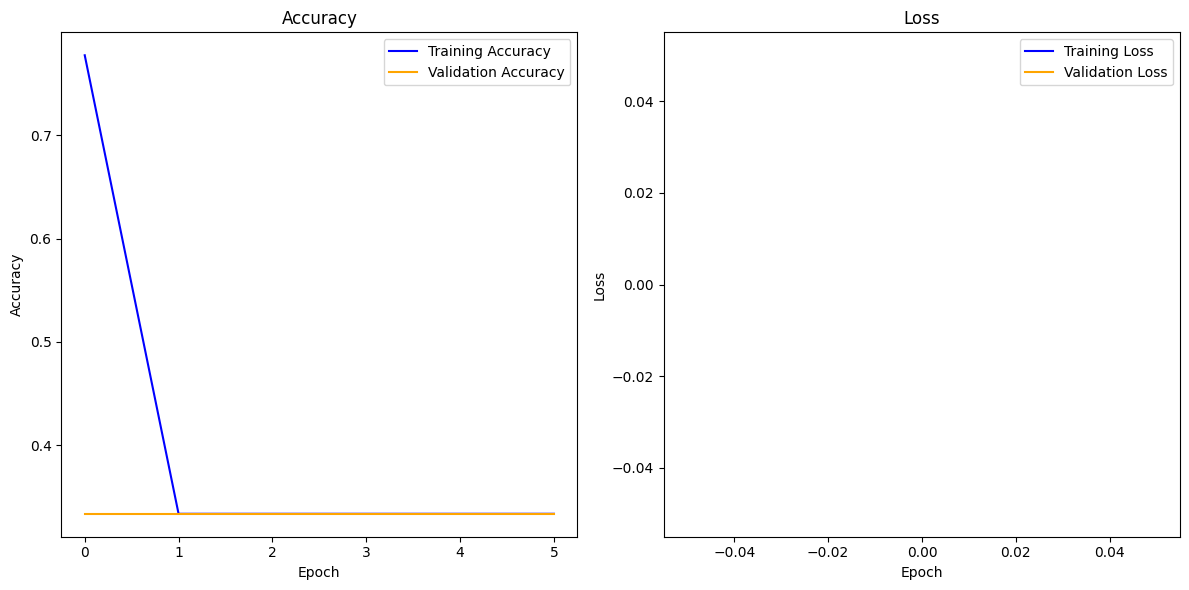

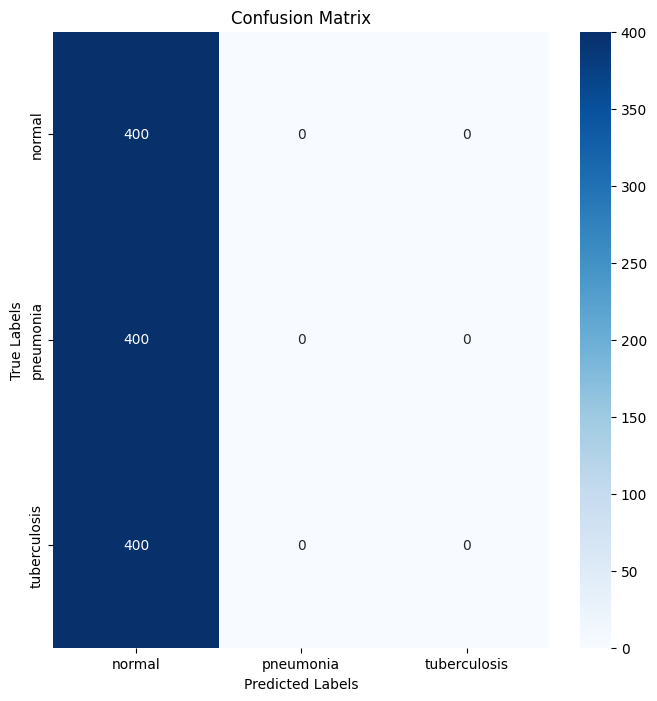

Classification Report for InceptionV3:
              precision    recall  f1-score   support

      normal       0.33      1.00      0.50       400
   pneumonia       0.00      0.00      0.00       400
tuberculosis       0.00      0.00      0.00       400

    accuracy                           0.33      1200
   macro avg       0.11      0.33      0.17      1200
weighted avg       0.11      0.33      0.17      1200



c:\Users\faith\anaconda3\envs\chexscan_\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\faith\anaconda3\envs\chexscan_\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\faith\anaconda3\envs\chexscan_\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [21]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

inception_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

inception_model = tf.keras.Model(inputs=inception_model.input, outputs=inception_top(inception_model.output))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

inception_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history_inception = inception_model.fit(train_generator, 
                                        validation_data=valid_generator, 
                                        epochs=num_epochs, 
                                        callbacks=[early_stopping])

true_labels_inception, predicted_labels_inception = evaluate_model(inception_model, valid_generator)
accuracy_inception = accuracy_score(true_labels_inception, predicted_labels_inception)
print("InceptionV3 Accuracy:", accuracy_inception)

plot_history_metrics(history_inception)

plot_confusion_matrix(true_labels_inception, predicted_labels_inception, CLASSES)

print("Classification Report for InceptionV3:")
print(classification_report(true_labels_inception, predicted_labels_inception, target_names=CLASSES))


## Performance Metrics

AlexNet Accuracy: 94.50%
DenseNet121 Accuracy: 94.00%
InceptionV3 Accuracy: 33.33%
ResNet50 Accuracy: 79.33%
VGG16 Accuracy: 99.17%


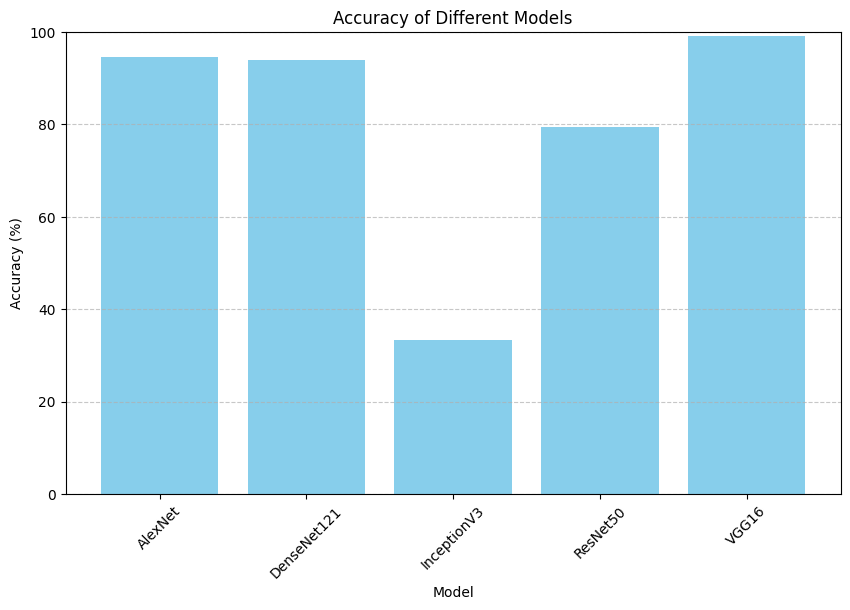

In [22]:
import matplotlib.pyplot as plt

accuracy_alexnet_percent = accuracy_alexnet * 100
accuracy_densenet_percent = accuracy_densenet * 100
accuracy_inception_percent = accuracy_inception * 100
accuracy_resnet_percent = accuracy_resnet * 100
accuracy_vgg_percent = accuracy_vgg * 100

print(f"AlexNet Accuracy: {accuracy_alexnet_percent:.2f}%")
print(f"DenseNet121 Accuracy: {accuracy_densenet_percent:.2f}%")
print(f"InceptionV3 Accuracy: {accuracy_inception_percent:.2f}%")
print(f"ResNet50 Accuracy: {accuracy_resnet_percent:.2f}%")
print(f"VGG16 Accuracy: {accuracy_vgg_percent:.2f}%")

models = ['AlexNet', 'DenseNet121', 'InceptionV3', 'ResNet50', 'VGG16']
accuracies = [accuracy_alexnet_percent, accuracy_densenet_percent, accuracy_inception_percent, accuracy_resnet_percent, accuracy_vgg_percent]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Ensemble

In [ ]:
# Define the trained models in a list
# top_models = [alexnet_model, densenet_model, inception_model, resnet_model, vgg_model]
top_models = [vgg_model, densenet_model, alexnet_model]

In [ ]:
for i, model in enumerate(top_models, start=1):
    model_path = f"final_model/selected_model_{i}.h5"
    model.save(model_path)

In [ ]:
def ensemble_predict(image, t3models):
    predictions = [model.predict(np.expand_dims(image, axis=0)) for model in t3models]
    return np.mean(predictions, axis=0)

## Saving the Ensemble Model

In [ ]:
# Load and preprocess the image
image_path = "E:/chexscan/exp/test/normal.png"
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image = cv2.resize(image, (224, 224))  # Resize to the required input size

# Convert image to NumPy array if it's not already and cast it to float32
image = np.array(image, dtype=np.float32)

# Normalize the pixel values
image /= 255.0

# Get ensemble predictions for the image
ensemble_predictions = ensemble_predict(image, top3_models)

# Display the ensemble predictions for the image
for class_index, class_name in enumerate(CLASSES):
    print(f"Ensemble Prediction for class '{class_name}': {ensemble_predictions[0][class_index]:.2f}")

print("ensemble predictions: ", ensemble_predictions)

# Convert predictions to class labels
predicted_class_indices = np.argmax(ensemble_predictions, axis=1)
predicted_class_names = [CLASSES[i] for i in predicted_class_indices]


<!-- # Make predictions using the ensemble model
predictions = ensemble_model.predict(input_image)

# Extract class names and corresponding probabilities
class_names = ["normal", "pneumonia", "tuberculosis"]  # Replace with your actual class names
probabilities = predictions[0]

# Sort the probabilities in descending order
sorted_indices = np.argsort(probabilities)[::-1]

# Display the top predicted class and its confidence
top_class = class_names[sorted_indices[0]]
top_confidence = probabilities[sorted_indices[0]]
print(f"Top predicted class: {top_class}, Confidence: {top_confidence:.2f}")

# Display the next two predicted classes and their confidences
for i in range(1, 3):
    class_name = class_names[sorted_indices[i]]
    confidence = probabilities[sorted_indices[i]]
    print(f"Predicted class {i+1}: {class_name}, Confidence: {confidence:.2f}") -->


In [ ]:
# Define the input shape based on your models
input_shape = (224, 224, 3)  # Ex|ample input shape for RGB images of size 299x299

# Define inputs for the ensemble model
ensemble_inputs = [Input(shape=input_shape) for _ in range(len(top3_models))]

# Get outputs of the top 3 models
model_outputs = [model(inputs) for model, inputs in zip(top3_models, ensemble_inputs)]

# Average the outputs
ensemble_output = Average()(model_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=ensemble_inputs, outputs=ensemble_output)

# Compile the ensemble model (if needed)
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('ensemble_model_04.h5')

In [ ]:
ensemble_model.save('ensemble_model_05.keras')

In [ ]:
alexnet_model.save('alexnet_model.keras')
densenet_model.save('densenet_model.keras')
inception_model.save('inception_model.keras')
resnet_model.save('resnet_model.keras')
vgg_model.save('vgg_model.keras')